In [2]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pandas as pd
import re
from sklearn.model_selection import train_test_split


# SENTIMENT ANALYSIS: Amazon Customer Reviews

# This project uses a version of the Amazon Review Dataset that was significantly reduced in size.
# The aim is to classify reviews into categories: positive, negative, or neutral. This can provide
# valuable insights for businesses to understand customer sentiment and improve their products or services.


# Load the Amazon Customer Review Dataset


df = pd.read_csv("C:\\Users\\ssain\\Downloads\\amazondata.csv", low_memory=False)

In [3]:
# View the dataset
df


,Helpful Votes (bin),Number of Records,Star Rating (bin),Customer Id,Helpful Votes,Overall Votes,Product Id,Review Body,Review Year,Review Headline,Star Rating
0,0,1,0,NaN,4.0,14.0,26009102,You will love this book. It is a hard long re...,03/17/2005 0:00,Best Book Ever,5.0
1,NaN,1,NaN,NaN,NaN,NaN,7491727,This is the UK edition of Dr. Omit's book. Dr....,NaN,researchers from John Hopkins School of Medici...,NaN
2,0,1,0,NaN,2.0,2.0,002782683X,This is a fun and entertaining book about lear...,06/25/2012 0:00,Michelle,5.0
3,0,1,0,NaN,0.0,0.0,60187271,"Started a big slow, but once into it the autho...",06/09/2013 0:00,Loved the book,5.0
4,0,1,0,NaN,14.0,20.0,60392452,Received this book as a Christmas present. I h...,08/05/2003 0:00,Challenges your assumptions,4.0
...,...,...,...,...,...,...,...,...,...,...,...
128840,0,1,0,NaN,4.0,6.0,60529148,John Stossel explains within these pages how h...,05/19/2004 0:00,Heroic,4.0
128841,NaN,1,NaN,NaN,NaN,NaN,60579412,When Bill Clinton said that we were all cold w...,NaN,the record needed to be set straight. Mona Ch...,NaN
128842,NaN,1,NaN,NaN,NaN,NaN,60184973,"During her reign, Queen Mary foiled several pl...",NaN,Queen of Scots -- but then,NaN
128843,0,1,0,NaN,1.0,1.0,7444117,I just don't understand how this was supposed ...,03/26/2014 0:00,So upsetting,2.0


In [4]:
# Number of Rows and Columns:

df.shape

(128845, 11)

In [5]:
# column datatypes

df.dtypes

Helpful Votes (bin)     object
Number of Records       object
Star Rating (bin)       object
Customer Id            float64
Helpful Votes          float64
Overall Votes          float64
Product Id              object
Review Body             object
Review Year             object
Review Headline         object
Star Rating            float64
dtype: object

In [6]:
# Missing values

df.isnull().sum()

Helpful Votes (bin)    13898
Number of Records          2
Star Rating (bin)      12534
Customer Id            68865
Helpful Votes          13902
Overall Votes          12724
Product Id                 5
Review Body               11
Review Year            13912
Review Headline           14
Star Rating            12540
dtype: int64

DATA PREPROCESSING:

In [11]:
# The key tasks in this stage will be:

# Handling Missing Values: Removing or imputing missing values in crucial columns like 
#'Review Body' and 'Star Rating'.

# Type Conversion: Converting the data types of columns, if necessary.

# Text Cleaning: Removing special characters, converting all text to lowercase, etc., in the
# 'Review Body' column.

In [12]:
# We have:

# 11 missing values in the 'Review Body' column
# 12,540 missing values in the 'Star Rating' column

# Handling Missing Values:
#'Review Body': Given that there are only 11 missing values, it's reasonable to simply remove these
# rows from the dataset. The 'Review Body' is crucial for our text-based sentiment analysis.

# 'Star Rating': We have a larger number of missing values here. Since we're planning to use 'Star Rating'
# as labels for training our sentiment analysis model, rows with missing 'Star Rating' won't be useful.
# We should  remove these as well.

In [7]:
# Remove rows with missing values in the key columns
df_clean = df.dropna(subset=['Review Body', 'Star Rating']).copy()

# Check the new dimensions of the DataFrame and verify the missing values are removed
num_rows_clean, num_cols_clean = df_clean.shape
missing_review_body_clean = df_clean['Review Body'].isnull().sum()
missing_star_rating_clean = df_clean['Star Rating'].isnull().sum()

print(f"Number of rows after cleaning: {num_rows_clean}")
print(f"Number of columns: {num_cols_clean}")
print(f"Missing values in 'Review Body': {missing_review_body_clean}")
print(f"Missing values in 'Star Rating': {missing_star_rating_clean}")


Number of rows after cleaning: 116299
Number of columns: 11
Missing values in 'Review Body': 0
Missing values in 'Star Rating': 0


In [8]:
# We'll remove special characters and convert all text to lowercase.

# The expression re.sub(r'[^\w\s]', '', text) effectively removes all special characters
# from the input text,leaving only alphanumeric characters and spaces.

# Function to clean text
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert text to lowercase
    return text

# Apply the function to the 'Review Body' column
df_clean['Cleaned_Review_Body'] = df_clean['Review Body'].apply(clean_text)

# Check the first few rows to see the cleaned text
print(df_clean[['Review Body', 'Cleaned_Review_Body']].head())


                                         Review Body  \
0  You will love this book.  It is a hard long re...   
2  This is a fun and entertaining book about lear...   
3  Started a big slow, but once into it the autho...   
4  Received this book as a Christmas present. I h...   
6  Ugly Impostor, discernible face, self esteem r...   

                                 Cleaned_Review_Body  
0  you will love this book  it is a hard long rea...  
2  this is a fun and entertaining book about lear...  
3  started a big slow but once into it the author...  
4  received this book as a christmas present i ha...  
6  ugly impostor discernible face self esteem rel...  


In [9]:
# Check unique values in 'Star Rating'
unique_star_ratings = df_clean['Star Rating'].unique()
print(f"Unique values in 'Star Rating': {sorted(unique_star_ratings)}")


Unique values in 'Star Rating': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 40.0, 41.0, 42.0, 43.0, 44.0, 47.0, 49.0, 52.0, 53.0, 54.0, 57.0, 58.0, 62.0, 63.0, 64.0, 68.0, 69.0, 73.0, 74.0, 101.0, 102.0, 112.0, 119.0, 125.0, 131.0, 152.0, 159.0, 171.0, 177.0, 190.0, 235.0, 2008.0]


In [16]:
# remove rows which have star rating that are not between 1-5. These ratings are likely erroneous.
df_filtered = df_clean[df_clean['Star Rating'].between(1, 5)].copy()

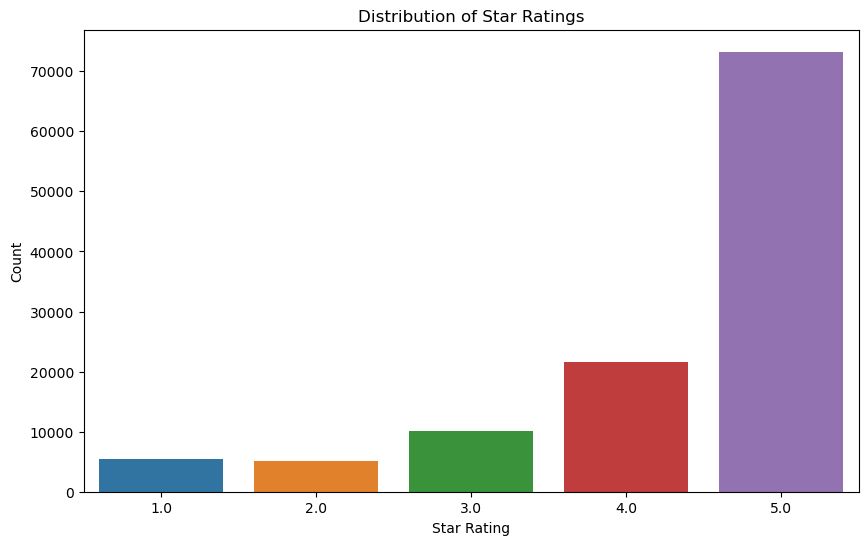

(115552, 12)

In [17]:
# plot the distribution of 'Star Rating'

import matplotlib.pyplot as plt
import seaborn as sns

new_shape = df_filtered.shape


plt.figure(figsize=(10, 6))
sns.countplot(x='Star Rating', data=df_filtered)
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.show()

new_shape

FEATURE ENGINEERING

In [18]:
# In this stage, we'll convert the text data from the 'Review Body' column into a numerical format
# that can be fed into machine learning algorithms.

# For this project, let's start with the TF-IDF approach, which is a commonly used technique that takes into
# account not just the occurrence of words in a single document (or review, in our case) but in the entire
# corpus of documents.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
# Limit to 5000 most frequent words to save memory and processing time
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  

# Fit and transform the 'Cleaned_Review_Body' column
tfidf_matrix = tfidf_vectorizer.fit_transform(df_filtered['Cleaned_Review_Body'])

# Check the shape of the resulting TF-IDF matrix
tfidf_shape = tfidf_matrix.shape
tfidf_shape

# The shape of the TF-IDF matrix indicates that we have successfully transformed 115,552 reviews into numerical
# vectors, each containing the TF-IDF scores for up to 5,000 unique words. This matrix will serve as the input
# for our machine learning model.

(115552, 5000)

In [20]:
# Create labels based on 'Star Rating'
def create_label(rating):
    if rating in [1, 2]:
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Positive'

# Apply the function to create a new 'Label' column
df_filtered['Label'] = df_filtered['Star Rating'].apply(create_label)


# Check the distribution of the labels
label_distribution = df_filtered['Label'].value_counts()
label_distribution

Positive    94898
Negative    10598
Neutral     10056
Name: Label, dtype: int64

In [23]:

# Split the TF-IDF matrix and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df_filtered['Label'], test_size=0.2, random_state=42)

# Check the shape of the resulting objects
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((92441, 5000), (23111, 5000), (92441,), (23111,))

In [21]:
# MODELING- Logistic Regression and Naive Bayes

In [27]:
# Model Training and Hyperparameter Optimization with Cross-Validation

# To maintain the integrity of the validation process and avoid data leakage, I'm integrating
# the resampling method within a pipeline for each classifier. The pipeline includes two main steps:
# 'resampling', where we apply Random Over Sampling, and 'classifier', where we employ the actual
# machine learning model (either Logistic Regression or Naive Bayes). This ensures that during each
# fold of the cross-validation process in GridSearchCV, only the training portion is resampled, leaving
# the validation set untouched.

# For hyperparameter tuning, GridSearchCV is employed with a specified range of hyperparameter values
# for each classifier. Specifically, for Logistic Regression, I experiment with different regularization
# strengths and penalty types, while for Naive Bayes, I explore varying smoothing parameters. 
# The best hyperparameters for each model are selected based on a 3-fold cross-validation.

# Once the best hyperparameters are determined, the model is trained on the entire resampled
# training set and evaluated on the final test set



# Hyperparameters and models
models_and_parameters = [
    {
        "name": "Logistic Regression",
        "model": LogisticRegression(max_iter=2000, random_state=42),
        "params": {
            "classifier__C": [0.1, 1, 10],
            "classifier__penalty": ["l1", "l2"],
            "classifier__solver": ["liblinear"]
        }
    },
    {
        "name": "Naive Bayes",
        "model": MultinomialNB(),
        "params": {
            "classifier__alpha": [0.5, 1, 2]
        }
    }
]

# Loop through models and hyperparameters, then print classification report
for mp in models_and_parameters:
    model_name = mp["name"]
    model = mp["model"]
    params = mp["params"]

    # Create a pipeline
    pipeline = Pipeline([
        ('resampling', RandomOverSampler(random_state=42)),
        ('classifier', model)
    ])

    # Grid Search with the pipeline
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=3)
    grid_search.fit(X_train, y_train)

    # Print the best parameters for each model
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

    # Make predictions on the test data
    y_pred = grid_search.predict(X_test)

    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    print("-" * 60)


Best parameters for Logistic Regression: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

    Negative       0.42      0.64      0.51      2105
     Neutral       0.27      0.52      0.35      2097
    Positive       0.96      0.80      0.87     18909

    accuracy                           0.76     23111
   macro avg       0.55      0.65      0.58     23111
weighted avg       0.85      0.76      0.79     23111

------------------------------------------------------------
Best parameters for Naive Bayes: {'classifier__alpha': 0.5}
Classification Report for Naive Bayes:
              precision    recall  f1-score   support

    Negative       0.38      0.62      0.47      2105
     Neutral       0.25      0.57      0.34      2097
    Positive       0.96      0.75      0.84     18909

    accuracy                           0.72     23111
   macro avg  

In [28]:
# Observations:
# Accuracy: Logistic Regression performs slightly better in terms of overall accuracy (76% vs 72%).

# Class-wise Performance: Both models struggle with the "Neutral" and "Negative" classes but perform 
# well on the "Positive" class. This is likely due to the class imbalance in the dataset.

# Recall: Both models have reasonably high recall for the "Negative" and "Neutral" classes, which means
# they are good at capturing the respective classes. However, the precision for these classes is lower,
# indicating a higher false positive rate.

# Positive Class: Both models have high precision but relatively lower recall for the "Positive" class.
# This suggests that when the models predict a review as positive, they are usually correct, but they
# miss a fair number of actual positive reviews.

# Hyperparameters: The best performing Logistic Regression model used L2 regularization with a 
# strength (C) of 1 and the 'liblinear' solver. For Naive Bayes, a smoothing parameter (alpha)
# of 0.5 was optimal.

# Logistic Regression seems to offer a better balance of precision and recall across all 
# classes based on the F1-scores. While the models do an okay job, especially for the "Positive" class,
# they are far from ideal for the "Neutral" and "Negative" classes. 
